In [1]:
# helpful packages:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path

# requiredpackages
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch import optim
!pip install torchmetrics
from torchmetrics import Accuracy, Precision, F1Score
import torch.utils.data as data

In [2]:
dir_path = Path('../input/satellite-image-classification/data')

In [3]:
# transform data
data_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
])

In [4]:
# load images to dataset 
datafolder = datasets.ImageFolder(dir_path, transform = data_transforms)
classes = datafolder.classes
print(classes)

['cloudy', 'desert', 'green_area', 'water']


label:0
torch.Size([224, 224, 3])


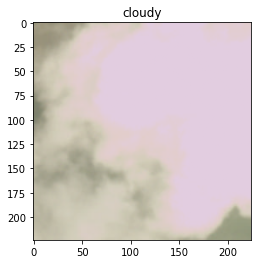

In [5]:
# load a sample
img, label = datafolder[0]
print(f'label:{label}')
img.shape
img_sample = img.permute(2, 1, 0)
print(img_sample.shape)
plt.imshow(img_sample)
plt.title(classes[label]);

In [6]:
# random split
train_set_size = int(len(datafolder) * 0.8)
valid_set_size = len(datafolder) - train_set_size
train_set, valid_set = data.random_split(datafolder, [train_set_size, valid_set_size])
print("Number of train data:", len(train_set))
print("Number of validation data:", len(valid_set))

Number of train data: 4504
Number of validation data: 1127


In [7]:
batch = 32
train_loader = DataLoader(dataset =train_set, batch_size =batch, shuffle = True)
val_loader = DataLoader(dataset= valid_set, batch_size = batch)
#dataloaders = {'train':train_loader,'val':val_loader}

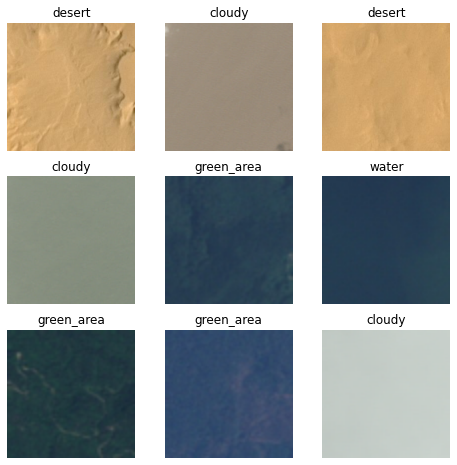

In [8]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    img = img.permute(2, 1, 0)
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [9]:
model = models.resnet18(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.01)
accuracy_fn = Accuracy(task="multiclass", num_classes=4)

In [11]:
train_set

In [12]:
num_epochs = 7

train_losses, train_acc = 0, 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    for batch, (X, y )in enumerate(train_loader):
        model.train()
        y_pred =model(X)
        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        train_losses += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses /= len(train_loader)
    train_acc /= len(train_loader)
    print(f' Train Loss: {train_losses:.4f} | Train Acc: {train_acc:.3f}')
    print()

Epoch 0/6
----------
 Train Loss: 0.2590 | Train Acc: 0.915

Epoch 1/6
----------
 Train Loss: 0.1115 | Train Acc: 0.976

Epoch 2/6
----------
 Train Loss: 0.0688 | Train Acc: 0.986

Epoch 3/6
----------
 Train Loss: 0.0515 | Train Acc: 0.991

Epoch 4/6
----------
 Train Loss: 0.0947 | Train Acc: 0.980

Epoch 5/6
----------
 Train Loss: 0.0574 | Train Acc: 0.990

Epoch 6/6
----------
 Train Loss: 0.0490 | Train Acc: 0.991



In [13]:
model.eval()
test_loss, test_acc = 0, 0
with torch.inference_mode():
    for batch_val, (X_val, y_val )in enumerate(val_loader):
        test_pred = model(X_val)
        t_loss = loss_fn(test_pred, y_val)
        test_loss += t_loss
        test_acc += accuracy_fn(test_pred.argmax(dim=1), y_val)
    test_loss /= len(val_loader)
    test_acc /= len(val_loader)
    print(f' Test Loss {test_loss:.4f} | Test Acc: {test_acc:.2f}   ')

 Test Loss 0.0247 | Test Acc: 0.99   


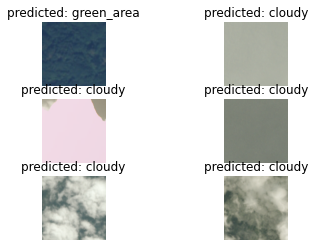

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                tensor_perm = inputs.permute(3,2,1,0)
                new_image = inputs.data[j].numpy()
                plt.imshow(new_image.transpose((1, 2, 0)))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(model)